# Projekt końcowy PwC
Skład grupy projektowej: Magdalena Lamczyk, Wiktoria Sarabon\
Mentorzy: Anna Pielowska, Michał Sucharski

## Zadanie

**Krok 1**: Pobierz historyczne ceny akcji/surowców/walut dla dwóch aktywów, które uważasz za powiązane (inne niż do tej pory). Skomentuj wybór. Przekształć pobrane dane w szeregi czasowe strat o wybranej częstotliwości i zakresie.\
**Krok 2**: Oblicz podstawowe statystyki, dopasuj rozkłady brzegowe, narysuj wykres obu szeregów, policz ich korelację Spearmana/tau Kendalla/dowolne wybrane miary zależności i skomentuj wszystkie analizy.\
**Krok 3**: Dopasuj różne kopuły (T-Studenta, normalną, Claytona, Franka, Gumbela) do połączonych szeregów czasowych strat i użyj kryteriów log-likelihood, AIC i BIC, aby wybrać najlepiej dopasowaną kopułę. Wykonaj test Mardia dla zbadania wielowymiarowej normalności. Skomentuj wyniki. Narysuj wykres dopasowania najlepszej kopuły do danych historycznych.\
**Krok 4a**: Wygeneruj $N$ wektorów ($x_1,x_2$) za pomocą dopasowanych rozkładów brzegowych (traktując oba rozkłady aktywów niezależnie, brak wykorzystania kopuły). Dopasuj taki parametr $\beta \in [0,1]$, że VaR dla portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy. Zinterpretuj wartość $\beta$.\
**Krok 4b**: Wygeneruj $N$ wektorów ($x_1,x_2$) za pomocą dopasowanej kopuły z rozkładów brzegowych (wektory będą wówczas zawierać zależność narzuconą przez dopasowaną kopułę). Dopasuj taki parametr $\beta \in [0,1]$, że VaR dla portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy. Zinterpretuj wartość $\beta$. Porównaj wyniki z krokiem 4a i skomentuj różnice.\
**Krok 5**: Porównaj wyniki z 4a i 4b. Sprawdź, jak zmieniają się wyniki dla dwóch różnych poziomów VaR i wartości $N$. Skomentuj.

## Importy

In [1]:
# pip install numpy pandas seaborn matplotlib yfinance pymannkendall statsmodels scipy sklarpy copulas pingouin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import yfinance as yf
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, kstest, shapiro, t, pearsonr, kendalltau, spearmanr
from sklarpy.copulas import student_t_copula, gaussian_copula, clayton_copula, gumbel_copula, frank_copula
import warnings
warnings.filterwarnings("ignore")
from sklarpy.univariate import student_t
from copulas.univariate import (
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate,
    LogLaplace,
    TruncatedGaussian,
    UniformUnivariate
)
from copulas.univariate.selection import select_univariate
from copulas.multivariate import GaussianMultivariate
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.bivariate import select_copula
from pingouin import multivariate_normality
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

## Pobranie danych przez API
Źródło danych Yahoo Finance: https://finance.yahoo.com/chart/AAPL, https://finance.yahoo.com/chart/MSFT.

**AAPL (Apple Inc.) i MSFT (Microsoft Corporation)**\
Obie firmy działają w sektorze technologii, co sugeruje potencjalną korelację ich cen akcji. Zarówno Apple, jak i Microsoft to liderzy rynku w swoich obszarach (hardware i software), więc zmiany w sektorze technologicznym mogą wpływać na obie firmy w podobny sposób.

In [2]:
tickers = ["AAPL", "MSFT"]
data = yf.download(tickers, start="2020-01-01", end="2023-12-31", interval="1d")
data.columns = ["_".join(col).strip() for col in data.columns]
data.head()

[*********************100%***********************]  2 of 2 completed


,Close_AAPL,Close_MSFT,High_AAPL,High_MSFT,Low_AAPL,Low_MSFT,Open_AAPL,Open_MSFT,Volume_AAPL,Volume_MSFT
Date,,,,,,,,,,
2020-01-02,72.796021,153.630707,72.856613,153.735921,71.545387,151.440361,71.799873,151.870777,135480400,22622100
2020-01-03,72.088280,151.717728,72.851746,152.989855,71.862877,151.182098,72.020416,151.430794,146322800,21116200
2020-01-06,72.662704,152.109879,72.701485,152.176840,70.953995,149.699531,71.206062,150.244735,118387200,20813700
2020-01-07,72.320961,150.723007,72.929306,152.722059,72.100403,150.474326,72.672394,152.387297,108872000,21634100
2020-01-08,73.484344,153.123764,73.787308,153.802875,72.022850,151.076886,72.022850,152.014237,132079200,27746500


## Eksploracyjna analiza danych
Pobraliśmy dzienne dane cen akcji Apple i Microsoft od początku 2020 roku do końca 2023 roku. Możemy sprawdzić wymiary zbioru danych:

In [3]:
print(data.shape)

(1006, 10)


Zbiór ma 12 kolumn i 1006 wierszy. Dane były zapisywane tylko w dni handlowe. Możemy sprawdzić różnice w indeksach:

In [4]:
data.index.to_series().diff().value_counts()

Date
1 days    792
3 days    177
4 days     31
2 days      5
Name: count, dtype: int64

Różnica 1 dnia to wpisy z dni roboczych. Różnica 2 dni występuje gdy święto przypada na inny dzień niż piątek lub poniedziałek. Różnica 3 dni odpowiada przerwom weekendowym, gdy giełda jest zamknięta w soboty i niedziele. Różnica 4 dni to przedłużone weekendy. Wyświetlimy podstawowe informacje o zbiorze danych:

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_AAPL   1006 non-null   float64
 1   Close_MSFT   1006 non-null   float64
 2   High_AAPL    1006 non-null   float64
 3   High_MSFT    1006 non-null   float64
 4   Low_AAPL     1006 non-null   float64
 5   Low_MSFT     1006 non-null   float64
 6   Open_AAPL    1006 non-null   float64
 7   Open_MSFT    1006 non-null   float64
 8   Volume_AAPL  1006 non-null   int64  
 9   Volume_MSFT  1006 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 86.5 KB
None


Indeks:
- Indeks składa się z dat i godzin. Dane obejmują okres od 2 stycznia 2020 (pierwszy dzień handlowy) do 29 grudnia 2023 (ostatni dzień handlowy). W zbiorze jest 1006 wierszy i jest to łączna liczba dni handlowych od początku 2020 roku do końca 2023 roku.

Dla akcji każdej firmy mamy po sześć kolumn o następujących oznaczeniach:
- **Adj Close**: skorygowana cena zamknięcia, uwzględnia takie zdarzenia jak podział akcji (split) czy dywidendy.
- **Close**: cena zamknięcia w danym dniu, czyli ostatnią cenę, po której akcje były handlowane na koniec dnia giełdowego.
- **High**: najwyższa cena w ciągu dnia handlowego.
- **Low**: najniższa cena w ciągu dnia handlowego.
- **Open**: cena otwarcia, czyli pierwsza cena, po której akcje były handlowane w danym dniu.
- **Volume**: liczba akcji, która zmieniła właściciela tego dnia.

Typy danych w kolumnach:
- float64 (10 kolumn): kolumny z wartościami liczbowymi zmiennoprzecinkowymi (ceny akcji).
- int64 (2 kolumny): kolumny z wartościami całkowitymi (Volume).

Możemy też sprawdzić podstawowe statysktyki zbioru:

In [6]:
print(data.describe())

        Close_AAPL   Close_MSFT    High_AAPL    High_MSFT     Low_AAPL  \
count  1006.000000  1006.000000  1006.000000  1006.000000  1006.000000   
mean    138.711616   256.641232   140.200764   259.302740   137.073406   
std      33.540053    55.341065    33.660802    55.477163    33.400150   
min      54.509766   129.881027    55.513133   134.820407    51.652723   
25%     121.054726   214.892303   122.302500   216.358720   119.513440   
50%     143.596542   253.355362   145.178997   255.872140   141.925951   
75%     164.086544   296.604317   166.375004   300.525893   162.826055   
max     197.144180   379.859467   198.646813   381.447555   196.039598   

          Low_MSFT    Open_AAPL    Open_MSFT   Volume_AAPL   Volume_MSFT  
count  1006.000000  1006.000000  1006.000000  1.006000e+03  1.006000e+03  
mean    253.735340   138.580866   256.531355  9.895211e+07  3.065417e+07  
std      55.111391    33.533754    55.367207  5.439653e+07  1.299798e+07  
min     127.099666    55.411096  

Wnioski:
- Wszystkie kolumny zawierają dane dla 1006 dni handlowych, co oznacza, że brak danych nie występuje.
- Średnia cena zamknięcia skorygowana dla AAPL wynosi 138.71 USD, a dla MSFT 256.64 USD. Medianowe wartości (percentyl 50%) są nieco wyższe, odpowiednio 143.60 USD i 253.36 USD, co sugeruje lekkie przesunięcie cen ku wyższym wartościom.
- Rozpiętość cen zamknięcia dla AAPL wynosi od 54.51 USD do 197.14 USD, a dla MSFT od 129.88 USD do 379.86 USD, co wskazuje na znaczne wahania cen w analizowanym okresie.
- Wartości kwartylowe pokazują, że przez większość czasu ceny zamknięcia AAPL znajdowały się w przedziale 121.05-164.09 USD, a dla MSFT w przedziale 214.89-296.60 USD.
- Średnia cena otwarcia dla AAPL to 140.68 USD, a dla MSFT 262.67 USD, co jest zbliżone do średnich cen zamknięcia, wskazując na stabilność cen w trakcie dnia.
- Średnia dzienna zmienność (rozpiętość między najwyższą a najniższą ceną) wynosi około 33.43 USD dla AAPL i 54.73 USD dla MSFT.
- Średni wolumen obrotu dla AAPL to 98.95 milionów akcji, a dla MSFT 30.65 milionów akcji dziennie. Duże odchylenia standardowe (54.40 mln dla AAPL i 12.99 mln dla MSFT) wskazują na zróżnicowaną aktywność inwestorów w poszczególnych dniach.
- Najwyższe wartości wolumenu obrotu dla AAPL wynoszą 426.51 mln akcji, co jest czterokrotnością medianowego wolumenu (84.68 mln akcji) i sugeruje występowanie dni o wyjątkowo dużym zainteresowaniu rynkowym.

Interesują nas kolumny opisujące ceny zamknięcia. Możemy przedstawić szeregi czasowe cen zamknięcia na wykresie:

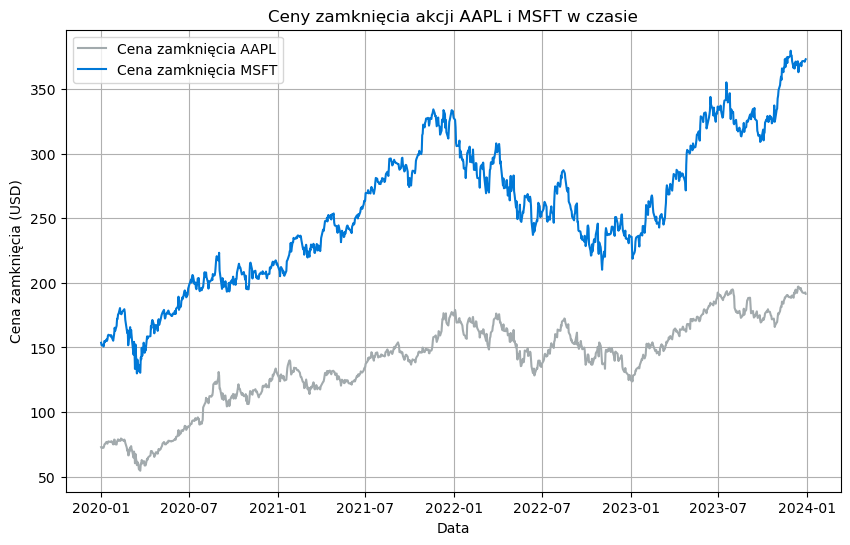

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close_AAPL"], color='#A2AAAD', label="Cena zamknięcia AAPL")
plt.plot(data.index, data["Close_MSFT"], color='#0078D7', label="Cena zamknięcia MSFT")
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia (USD)")
plt.title("Ceny zamknięcia akcji AAPL i MSFT w czasie")
plt.legend()
plt.grid()
plt.show()

Z wykresu można zauważyć, że obie zmienne (ceny zamknięcia akcji AAPL i MSFT) wykazują pewne podobieństwa w trendach (wykazują ogólny trend wzrostowy), co sugeruje, że mogą być skorelowane. Obecnośc tendu możemy zweryfikować za pomocą testu Manna-Kendalla:

In [8]:
trend_test1 = mk.original_test(data['Close_AAPL'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: increasing
Nachylenie: 0.10215111585542154
p-value: 0.0


In [9]:
trend_test2 = mk.original_test(data['Close_MSFT'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: increasing
Nachylenie: 0.16760279162176725
p-value: 0.0


Test potwierdza obecność trednu rosnącego dla obu szeregów. Zróżnicowanie danych może pomóc w usunięciu trendu i sprawieniu, by szeregi czasowe stały się stacjonarne (czyli ich statystyki (średnia, wariancja, kowariancja) nie zmieniały się w czasie).

## Zróżnicowanie szeregów czasowych
Nasze dane są nieciągłe (brakuje weekendów i świąt), więc różnicowanie będzie dotyczyło tylko dni handlowych. Uzupełnianie brakujących dni sztucznymi wartościami (np. przez forward fill) może wprowadzić fałszywe informacje do analizy. W rezultacie uwzględniamy tylko rzeczywiste zmiany cen w dostępnych datach.

In [10]:
data["diff_aapl"] = data["Close_AAPL"].diff()
data["diff_msft"] = data["Close_MSFT"].diff()
data = data.dropna()

Możemy wyświetlić podstawowe statystyki otrzymanych szeregów start:

In [11]:
print(data[["diff_aapl","diff_msft"]].describe())

         diff_aapl    diff_msft
count  1005.000000  1005.000000
mean      0.118204     0.218526
std       2.603360     4.724795
min     -10.269295   -22.452484
25%      -1.277176    -2.387589
50%       0.148880     0.248672
75%       1.613174     2.996643
max      11.875122    19.677002


Wnioski:
- Średnia dzienna zmiana ceny dla AAPL wynosi 0.12 USD, a dla MSFT 0.21 USD, co sugeruje, że MSFT wykazuje większe dzienne wzrosty w analizowanym okresie.
- Odchylenie standardowe wynosi 2.65 USD dla AAPL i 4.85 USD dla MSFT, wskazując na znacznie większą zmienność cen akcji MSFT w porównaniu do AAPL.
- Minimalne dzienne zmiany to -10.52 USD dla AAPL i -23.41 USD dla MSFT, co świadczy o istnieniu dni z dużymi spadkami cen.
- Maksymalne dzienne wzrosty wynoszą 12.00 USD dla AAPL i 19.95 USD dla MSFT, co pokazuje potencjalne znaczące skoki cen w niektórych dniach.
- W 25% przypadków zmiany dzienne AAPL wynosiły mniej niż -1.30 USD, a dla MSFT mniej niż -2.45 USD.
- Mediana zmian dziennych to 0.15 USD dla AAPL i 0.23 USD dla MSFT, co oznacza, że zmiany były najczęściej bliskie zeru lub nieznacznie dodatnie.
- W 75% przypadków zmiany dzienne AAPL wynosiły mniej niż 1.66 USD, a dla MSFT mniej niż 3.06 USD.

Ogólnie, akcje MSFT wykazują większą zmienność zarówno w górę, jak i w dół w porównaniu do AAPL. Sprawdzimy na wykresie jak zmieniły się dane:

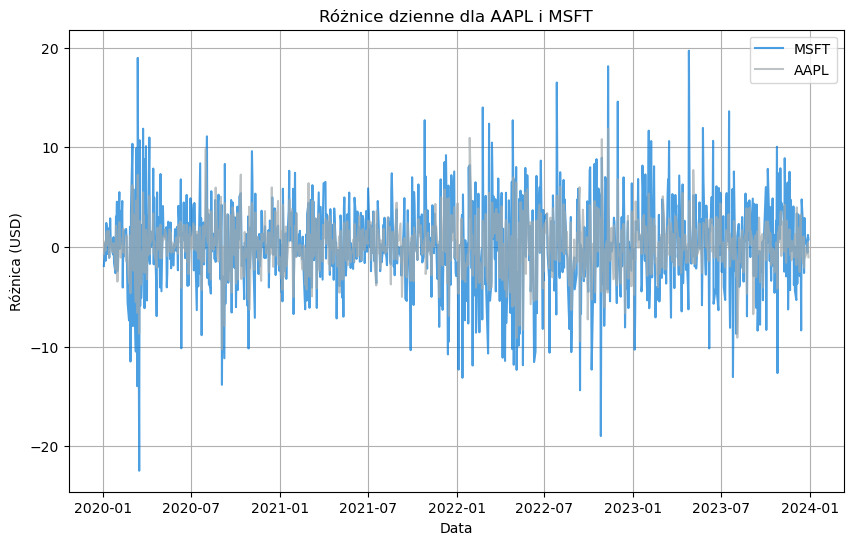

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff_msft"], label="MSFT", color="#0078D7", alpha=0.7)
plt.plot(data.index, data["diff_aapl"], label="AAPL", color="#A2AAAD", alpha=0.7)
plt.title("Różnice dzienne dla AAPL i MSFT")
plt.xlabel("Data")
plt.ylabel("Różnica (USD)")
plt.legend()
plt.grid(True)
plt.show()

Na wykresie nie zauważamy wyraźnego trendu. Sprawdzimy to za pomocą testu Manna-Kendalla:

In [13]:
trend_test1 = mk.original_test(data['diff_aapl'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: no trend
Nachylenie: -7.911131126822046e-05
p-value: 0.7519628657959392


In [14]:
trend_test2 = mk.original_test(data['diff_msft'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: no trend
Nachylenie: -6.316242968787246e-05
p-value: 0.8955718674336641


Test potwierdza pozbycie się trendu dla obu szeregów. Możemy również przetestować stacjonarność zróżnicowanych szeregów za pomocą rozszerzonego testu Dickey-Fullera (ADF):

In [15]:
result1 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result1[1]}")

if result1[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.


In [16]:
result2 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result2[1]}")

if result2[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.


Możemy odrzucić hipotezę zerową, oba szeregi strat są stacjonarne. Sprawdzimy wartości odstające:

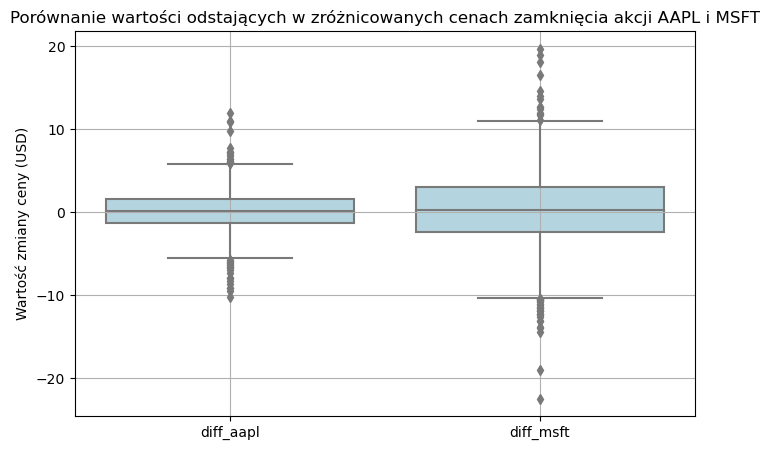

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data[["diff_aapl","diff_msft"]], color='lightblue')
plt.title("Porównanie wartości odstających w zróżnicowanych cenach zamknięcia akcji AAPL i MSFT")
plt.xlabel("")
plt.ylabel("Wartość zmiany ceny (USD)")
plt.grid(True)
plt.show()

- Mediana zmian cen akcji Apple (diff_aapl) jest bliska zeru, co sugeruje, że większość zmian cen jest niewielka. Mediana zmian cen akcji Microsoft (diff_msft) jest również bliska zeru.
- Rozstęp międzykwartylowy dla Apple jest mniejszy niż dla Microsoft, co oznacza, że zmiany cen akcji Apple są mniej zróżnicowane niż zmiany cen akcji Microsoft.
- W obu przypadkach widoczne są wartości odstające, które są bardziej liczne w przypadku Microsoft. Wartości te reprezentują dni, w których zmiany cen były znacznie większe niż w pozostałych dniach.

Policzymy korelację liniową, statystyki Tau Kendalla oraz Rho Spearmana w celu oceny zależności pomiędzy zmiennymi.
Korelacja Pearsona mierzy liniową zależność między zmiennymi. Wynik to współczynnik korelacji Pearsona (wartość od -1 do 1) i wartość p, która ocenia istotność tej korelacji.

In [18]:
pearson_corr, pearson_p = pearsonr(data["diff_aapl"], data["diff_msft"])
print(f"Korelacja Pearsona: {pearson_corr}, p-value: {pearson_p}")

Korelacja Pearsona: 0.7208060413584919, p-value: 7.662852577790345e-162


Wartość 0.721 wskazuje na silną, dodatnią zależność liniową między cenami zamknięcia akcji AAPL i MSFT. Wartość p jest bardzo mała ($2.14 \times 10^{-162}$), co oznacza, że zależność jest statystycznie istotna.

Statystyka Tau Kendalla mierzy monotoniczną zależność między zmiennymi na podstawie par porównywalnych.

In [19]:
kendall_corr, kendall_p = kendalltau(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Tau Kendalla: {kendall_corr}, p-value: {kendall_p}")

Statystyka Tau Kendalla: 0.5581550232416986, p-value: 1.097383041178388e-154


Wartość 0.558 wskazuje na umiarkowaną dodatnią monotoniczną zależność między zmiennymi. Tau Kendalla jest bardziej odporny na wartości odstające niż korelacja Pearsona. Bardzo niski poziom p ($1.29 \times 10^{-154}$) wskazuje, że zależność jest istotna.

Statystyka Rho Spearmana mierzy monotoniczną zależność na podstawie rang zmiennych.

In [20]:
spearman_corr, spearman_p = spearmanr(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Rho Spearmana: {spearman_corr}, p-value: {spearman_p}")

Statystyka Rho Spearmana: 0.7378622423645812, p-value: 1.9639321123668025e-173


Wartość 0.738 wskazuje na silną dodatnią monotoniczną zależność między zmiennymi. Rho Spearmana, podobnie jak Tau Kendalla, opiera się na rangach i jest mniej wrażliwy na wartości odstające. Bardzo mała wartość p ($2.83 \times 10^{-173}$) wskazuje na istotność statystyczną tej zależności.

Wnioski:
- Wszystkie trzy miary korelacji wskazują, że istnieje statystycznie istotna zależność między zmianami wartości diff_aapl i diff_msft.
- Korelacja Pearsona sugeruje, że zależność liniowa jest silna (0.721). Tau Kendalla i Spearmana wskazują na umiarkowaną i silną zależność monotoniczną.

## Dopasowanie rozkładów

Za pomocą histogramów możemy zobaczyć, jak rozkładają się wartości w zróżnicowanych szeregach cen akcji AAPL i MSFT:

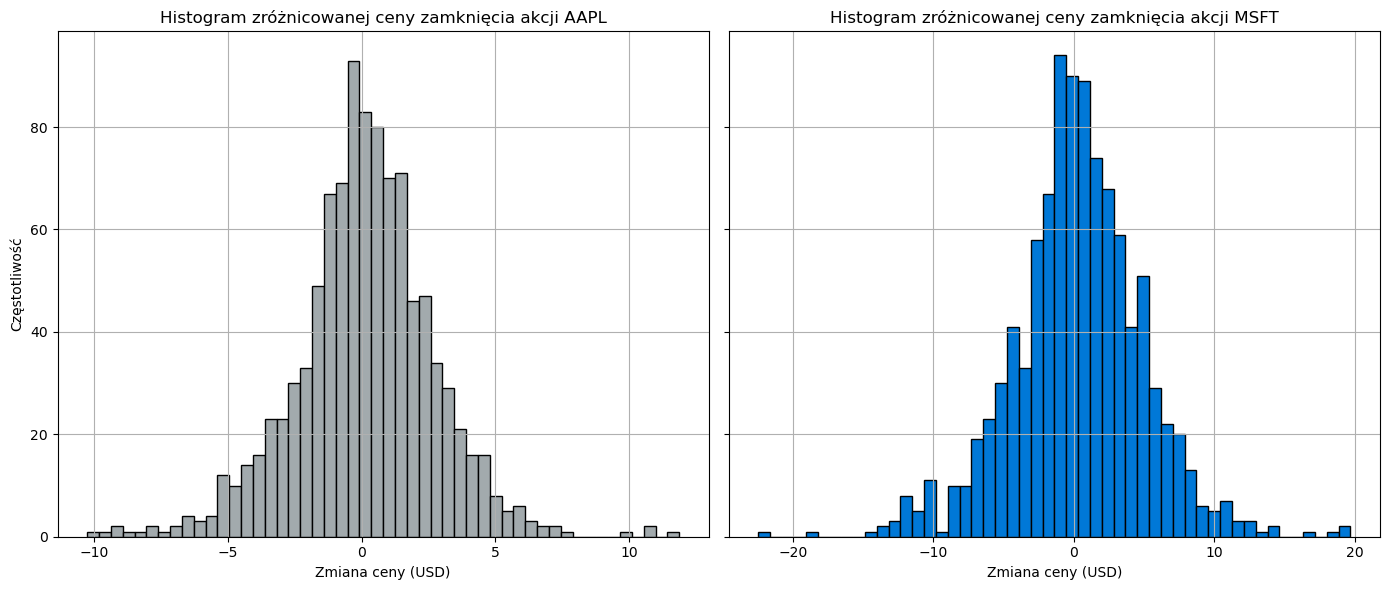

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].hist(data["diff_aapl"], bins=50, edgecolor='k', color='#A2AAAD')
axes[0].set_title("Histogram zróżnicowanej ceny zamknięcia akcji AAPL")
axes[0].set_xlabel("Zmiana ceny (USD)")
axes[0].set_ylabel("Częstotliwość")
axes[0].grid(True)

axes[1].hist(data["diff_msft"], bins=50, edgecolor='k', color='#0078D7')
axes[1].set_title("Histogram zróżnicowanej ceny zamknięcia akcji MSFT")
axes[1].set_xlabel("Zmiana ceny (USD)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

- Oba histogramy mają kształt zbliżony do dzwonu, co sugeruje, że zmiany cen mogą pochodzić z rozkładów normalnych.
- Histogram dla AAPL jest bardziej symetryczny i skoncentrowany wokół zera, co oznacza, że zmiany ceny zamknięcia akcji AAPL są bardziej stabilne i mniej zmienne.
- Histogram dla MSFT jest również zbliżony do rozkładu normalnego, ale ma nieco większą zmienność w porównaniu do AAPL, co może sugerować większą niestabilność cen akcji MSFT.

Przetestujemy, czy dane pochodzą z rozkładu normalnego za pomocą testu Shapiro-Wilka:

In [22]:
stat, p_value = shapiro(data["diff_aapl"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.")

Statystyka testowa: 0.9821599721908569
p-value: 9.46976164151181e-10
Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.


In [23]:
stat, p_value = shapiro(data["diff_msft"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.")

Statystyka testowa: 0.9836159348487854
p-value: 3.400359327443425e-09
Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.


Oba szeregi nie pochodzą z rozkładu normalnego. Czy pochodzą z rozkładu t-Studenta? Zastosujemy test Kołmogorowa-Smirnowa do oceny zgodności danych z rozkładem t-Studenta:

In [24]:
params = t.fit(data["diff_aapl"])

stat, p_value = kstest(data["diff_aapl"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem t-Studenta.")

Statystyka testowa: 0.016214608309635434
p-value: 0.9503492775076191
Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.


In [25]:
params = t.fit(data["diff_msft"])

stat, p_value = kstest(data["diff_msft"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem t-Studenta.")

Statystyka testowa: 0.021022929205848584
p-value: 0.7577903550694564
Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.


Zatem oba szeregi start mogą pochodzić z rozkładu t-Studenta.

## Dopasowanie kopuł - sklarpy (błąd z kopułą Claytona)
Dopasujemy pięć kopuł i ocenimy ich dopasowanie:
- eliptyczne - t-Studenta, normalna,
- archimedejskie - Gumbela, Claytona, Franka.

Sprawdzimy jak wygląda nasz rozkład łączny:

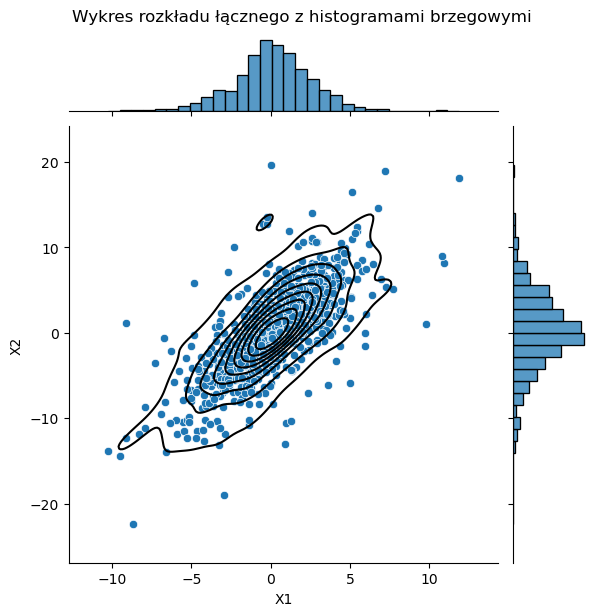

In [26]:
g = sns.jointplot(x="diff_aapl", y="diff_msft", data=data, kind="scatter", marginal_kws=dict(bins=30, fill=True))

g.fig.suptitle("Wykres rozkładu łącznego z histogramami brzegowymi", y=1.02)
sns.kdeplot(data=data, x="diff_aapl", y="diff_msft", color="black")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

Kontury mają kształt eliptyczny i są skoncentrowane wokół środka, co sugeruje, że rozkład jest symetryczny i dzwonowaty.

Ponieważ rozkłady brzegowe mogą pochodzić z rozkładu t-Studenta, przekształcimy szeregi na dystrybuanty brzegowe dopasowując rozkłady t-Studenta:

In [27]:
fitted_marginals = {
    0: student_t.fit(data["diff_aapl"]),
    1: student_t.fit(data["diff_msft"])
}

data["u1"] = fitted_marginals[0].cdf(np.array(data["diff_aapl"]))
data["u2"] = fitted_marginals[1].cdf(np.array(data["diff_msft"]))

### Kopuła T-Studenta

In [28]:
student_t_fit = student_t_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.DataFrame({
    "Copula": ["Student-t"],
    "Log-Likelihood": [student_t_fit.loglikelihood()],
    "AIC": [student_t_fit.aic()],
    "BIC": [student_t_fit.bic()]
})

print(results.loc[0])

Copula              Student-t
Log-Likelihood   -3611.296811
AIC               7238.593623
BIC               7277.895565
Name: 0, dtype: object


In [29]:
print("Liczba stopni swobody (dof):", student_t_fit.copula_params.dof) 
print("Macierz kowariancji (cov):", student_t_fit.copula_params.cov) 

Liczba stopni swobody (dof): 100.0
Macierz kowariancji (cov): [[1.02040816 0.7843497 ]
 [0.7843497  1.02040816]]


### Kopuła Gaussa

In [30]:
gaussian_fit = gaussian_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gaussian"],
        "Log-Likelihood": [gaussian_fit.loglikelihood()],
        "AIC": [gaussian_fit.aic()],
        "BIC": [gaussian_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[1])

Copula               Gaussian
Log-Likelihood   -3615.902927
AIC               7245.805854
BIC               7280.195054
Name: 1, dtype: object


In [31]:
print("Macierz kowariancji (cov):", gaussian_fit.copula_params.cov)

Macierz kowariancji (cov): [[1.        0.7686627]
 [0.7686627 1.       ]]


### Kopuła Claytona - zła, niedobra

In [32]:
clayton_fit = clayton_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals, verbose=True)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Clayton"],
        "Log-Likelihood": [clayton_fit.loglikelihood()],
        "AIC": [clayton_fit.aic()],
        "BIC": [clayton_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[2])

Copula                Clayton
Log-Likelihood    1339.086519
AIC              -2662.173038
BIC              -2622.871095
Name: 2, dtype: object


### Kopuła Gumbela

In [33]:
gumbel_fit = gumbel_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gumbel"],
        "Log-Likelihood": [gumbel_fit.loglikelihood()],
        "AIC": [gumbel_fit.aic()],
        "BIC": [gumbel_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[3])

Copula                 Gumbel
Log-Likelihood   -2594.319443
AIC               5204.638886
BIC               5243.940828
Name: 3, dtype: object


### Kopuła Franka

In [34]:
frank_fit = frank_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Frank"],
        "Log-Likelihood": [frank_fit.loglikelihood()],
        "AIC": [frank_fit.aic()],
        "BIC": [frank_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[4])

Copula                  Frank
Log-Likelihood   -2571.220312
AIC               5158.440624
BIC               5197.742567
Name: 4, dtype: object


Możemy ocenić dopasowanie kopuł za pomocą miar:
- Log-Likelihood: jest to miara, która ocenia, jak dobrze model kopuły pasuje do danych. Wyższa wartość log-likelihood wskazuje na lepsze dopasowanie modelu do danych.
- AIC (Akaike Information Criterion): AIC uwzględnia zarówno dopasowanie modelu, jak i jego złożoność. Niższa wartość AIC wskazuje na lepszy model, ponieważ oznacza lepsze dopasowanie przy mniejszej złożoności.
- BIC (Bayesian Information Criterion): BIC również uwzględnia dopasowanie modelu i jego złożoność, ale karze bardziej za złożoność niż AIC. Niższa wartość BIC wskazuje na lepszy model.
- 
Zatem niższe wartości AIC i BIC oraz wyższa wartość log-likelihood wskazują na lepsze dopasowanie kopuły do danych.

In [35]:
print("\nZestawienie wyników dla wszystkich kopuł:")
print(results)


Zestawienie wyników dla wszystkich kopuł:
      Copula  Log-Likelihood          AIC          BIC
0  Student-t    -3611.296811  7238.593623  7277.895565
1   Gaussian    -3615.902927  7245.805854  7280.195054
2    Clayton     1339.086519 -2662.173038 -2622.871095
3     Gumbel    -2594.319443  5204.638886  5243.940828
4      Frank    -2571.220312  5158.440624  5197.742567


Wyniki dla kopuły Claytona znacznie różnią się od pozostałych (w porównaniu do pozostałych wyglądają jak błąd lub nadmierne dopasowanie do danych). Przyjmiemy, że wynika to z błędu w impementacji tej kopuły. Aby wybrać najlepszą kopułę będziemy patrzeć na wyniki testu BIC. Posortujemy tabelę rosnąco względem kolumny BIC, więc najlepsza kopuła będzie na samej górze:

In [36]:
kopules = results.copy()

In [37]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

print("\nTabela z wynikami (posortowana według BIC):")
print(results_sorted)


Tabela z wynikami (posortowana według BIC):
      Copula  Log-Likelihood          AIC          BIC
0    Clayton     1339.086519 -2662.173038 -2622.871095
1      Frank    -2571.220312  5158.440624  5197.742567
2     Gumbel    -2594.319443  5204.638886  5243.940828
3  Student-t    -3611.296811  7238.593623  7277.895565
4   Gaussian    -3615.902927  7245.805854  7280.195054


Odrzucamy kopułę Claytona. Najlepsza kopuła wedlug BIC to kopuła Franka. Sprawdzimy dopasowanie kopuł za pomocą wykresów, generując z kopuł przykładowe próbki i porównując je z rozkładem łącznym oryginalnych danych. Możemy wygenerować próbki za pomocą metody rvs():

In [38]:
student_t_samples = student_t_fit.rvs(len(data))
gaussian_samples = gaussian_fit.rvs(len(data))
clayton_samples = clayton_fit.rvs(len(data))
gumbel_samples = gumbel_fit.rvs(len(data))
frank_samples = frank_fit.rvs(len(data))

Rysujemy wykresy rozkładu dwuwymiarowego uzywając sns.kdeplot(x,y). Punkty na wykresie oznaczają dane oryginalne, natomiast linie zostały wygenerowane na podstawie próbek z dopasowanych kopuł:

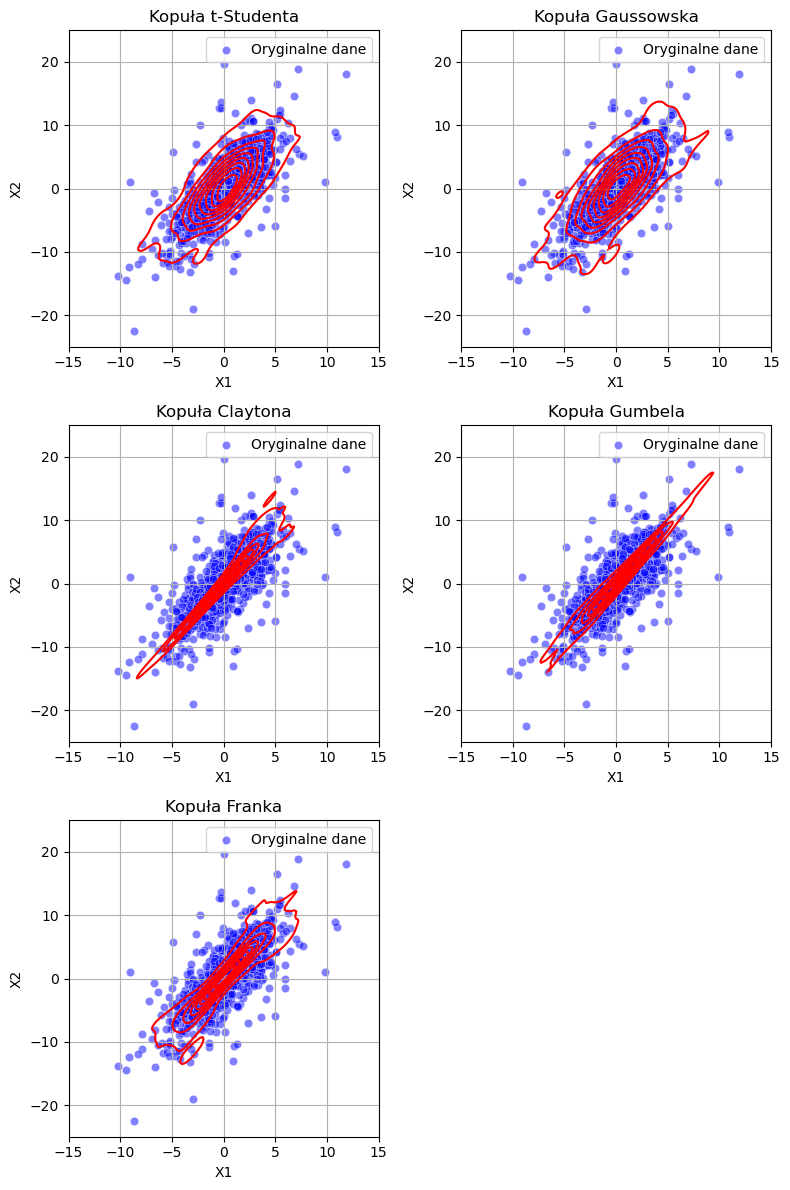

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
axes = ax.flatten()

copula_samples = [
    (student_t_samples, "Kopuła t-Studenta"),
    (gaussian_samples, "Kopuła Gaussowska"),
    (clayton_samples, "Kopuła Claytona"),
    (gumbel_samples, "Kopuła Gumbela"),
    (frank_samples, "Kopuła Franka")
]

for i, (samples, title) in enumerate(copula_samples):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

axes[-1].axis("off")

plt.tight_layout()
plt.show()

1. Kopuła t-Studenta dobrze radzi sobie z modelowaniem silnych zależności w ogonie rozkładu. Kształt kopuły pokazuje, że elipsa nie jest ani bardzo wydłużona (co wskazywałoby na silną zależność), ani bardzo okrągła (co oznaczałoby brak zależności).
2. Kopuła Gaussowska modeluje zależności w sposób bardziej symetryczny, co oznacza, że zależność między zmiennymi jest równomiernie rozłożona. Może nie radzić sobie dobrze z modelowaniem zależności w ogonach (ekstremalne wartości). Eliptyczny kształt wskazuje na równomierną korelację.
3. Kopuła Claytona dopasowuje się do liniowego trendu.
4. Kopuła Gumbela dopasowuje się do liniowego trendu.
5. Kopuła Franka modeluje zależności w sposób mniej eliptyczny niż Gaussowska. Nie jest szczególnie skoncentrowana na ogonach rozkładu, co czyni ją bardziej uniwersalną dla umiarkowanych zależności. Na wykresie widoczna jest równomierna struktura zależności.

Wyodrębnimy parametry do późniejszego porównania, jak poradzi sobie copulas z thetami, które wybrało sklarpy:

In [40]:
params = {
    "Copula": ["Clayton", "Gumbel", "Frank"],
    "Parametr Theta": [
        #gaussian_fit.correlation,
        clayton_fit.copula_params.theta,
        gumbel_fit.copula_params.theta,
        frank_fit.copula_params.theta
    ]
}

params_df = pd.DataFrame(params)
print(params_df)

    Copula  Parametr Theta
0  Clayton       28.991157
1   Gumbel       10.273737
2    Frank       31.689794


## Copulas - nie ma kopuły t-Studenta dla rozkładów dwuwymiarowych
Możemy wykorzystać wbudowaną metodę select_univariate() aby dopasować najlepsze rozkłady brzegowe:

In [41]:
candidates = [
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate
]

best_model1 = select_univariate(data["diff_aapl"], candidates)
best_model2 = select_univariate(data["diff_msft"], candidates)
print(f"Najlepszy rozkład brzegowy AAPL: {type(best_model1).__name__}")
print(f"Najlepszy rozkład brzegowy MSFT: {type(best_model2).__name__}")

Najlepszy rozkład brzegowy AAPL: StudentTUnivariate
Najlepszy rozkład brzegowy MSFT: StudentTUnivariate


Ponieważ rozkłady brzegowe mogą pochodzić z rozkładu t-Studenta, przekształcimy szeregi na dystrybuanty brzegowe dopasowując rozkłady t-Studenta:

In [42]:
marginal_aapl = StudentTUnivariate()
marginal_aapl.fit(data["diff_aapl"])
marginal_msft = StudentTUnivariate()
marginal_msft.fit(data["diff_msft"])

data["u1"] = marginal_aapl.cdf(data["diff_aapl"])
data["u2"] = marginal_msft.cdf(data["diff_msft"])
print(data[["u1", "u2"]].head())

                  u1        u2
Date                          
2020-01-03  0.348054  0.294176
2020-01-06  0.576105  0.511327
2020-01-07  0.410697  0.339524
2020-01-08  0.676031  0.700018
2020-01-09  0.735777  0.657655


W pętli dopasujemy kopuły Gaussa, Claytona, Franka i Gumbela (w pakiecie copulas nie ma kopuły t-Studenta dla rozkładów dwuwymiarowych, nie ma też wbudowanych funkcji liczących log-likelihood, AIC i BIC):

In [43]:
data_u = data[["u1", "u2"]].to_numpy()

copula_classes = [GaussianMultivariate, Clayton, Gumbel, Frank]
results = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)

    # Log-likelihood
    pdf_values = copula.probability_density(data_u)
    log_likelihood = np.sum(np.log(pdf_values))

    if isinstance(copula, GaussianMultivariate):
        # GaussianMultivariate: liczba parametrów korelacji + liczba parametrów brzegowych
        d = data_u.shape[1]  # Wymiar danych (liczba zmiennych)
        num_correlation_params = d * (d - 1) / 2  # Liczba niezależnych elementów w macierzy korelacji
        num_univariate_params = len(copula.univariates)  # Liczba dystrybucji brzegowych
        num_params = num_correlation_params + num_univariate_params
    else:
        # Clayton, Frank, Gumbel: 1 parametr theta
        num_params = 1

    n = len(data_u)

    # AIC i BIC
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(n)

    results.append({
        'Copula': copula_class.__name__,
        'Num_params': num_params,
        'Log-Likelihood': log_likelihood,
        'AIC': aic,
        'BIC': bic
    })

Wyniki możemy zestawić w tabeli:

In [44]:
results = pd.DataFrame(results)
print(results)

                 Copula  Num_params  Log-Likelihood          AIC          BIC
0  GaussianMultivariate         3.0    -2534.527362  5075.054724  5089.792953
1               Clayton         1.0      304.364135  -606.728269  -601.815526
2                Gumbel         1.0      374.963185  -747.926370  -743.013628
3                 Frank         1.0      409.988001  -817.976002  -813.063259


Aby wybrać najlepszą kopułę będziemy patrzeć na wyniki testu BIC. Posortujemy tabelę rosnąco względem kolumny BIC, więc najlepsza kopuła będzie na samej górze (im niższy wynik BIC tym lepiej):

In [45]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

print("\nTabela z wynikami (posortowana według BIC):")
print(results_sorted)


Tabela z wynikami (posortowana według BIC):
                 Copula  Num_params  Log-Likelihood          AIC          BIC
0                 Frank         1.0      409.988001  -817.976002  -813.063259
1                Gumbel         1.0      374.963185  -747.926370  -743.013628
2               Clayton         1.0      304.364135  -606.728269  -601.815526
3  GaussianMultivariate         3.0    -2534.527362  5075.054724  5089.792953


1. Kopuła Franka jest najlepsza. Osiąga najwyższą wartość log-likelihood (409.54). Ma najniższe wartości AIC (-817.07) i BIC (-812.16), co wskazuje na najlepsze dopasowanie z uwzględnieniem prostoty modelu. Jest najbardziej uniwersalna i dobrze radzi sobie z modelowaniem umiarkowanych zależności.
2. Gumbel jest drugim najlepszym modelem, ale znacznie gorszym od Franka. Może być odpowiednia, jeśli dane charakteryzują się silnymi zależnościami w górnym ogonie rozkładu.
3. Clayton nie radzi sobie dobrze z danymi w tej analizie, co sugeruje, że dane nie zawierają istotnych zależności w dolnym ogonie.
4. Gaussian Multivariate jest wyraźnie najgorsza. Ekstremalnie niskie log-likelihood i bardzo wysokie wartości AIC oraz BIC wskazują, że ta kopuła nie odwzorowuje danych w żaden sposób zgodny z ich strukturą. Wysokie wartości AIC i BIC wskazują na to, że model może być nadmiernie skomplikowany w stosunku do danych, które modeluje. Możliwe, że wynika to ze sposobu implementacji kopuły - GaussianMultivariate jest ogólną kopułą wielowymiarową, która może być mniej efektywna w modelowaniu danych o prostszej (dwuwymiarowej) strukturze.

Możemy sprawdzić jaką najlepszą kopułę wyłoni metoda select_copula() (wybiera tylko spośród kopuł dla rozkładów dwuwymiarowych, czyli Clayton, Frank i Gumbel):

In [46]:
best_copula = select_copula(data_u)
print(f"Best Copula: {best_copula.__class__.__name__}")

Best Copula: Clayton


Wybrało kopułę Claytona, ale patrząc na wyniki BIC nie jest to najlepszy wybór.

Wylosujemy próbki z dopasowanych kopuł aby zwizualizować kopuły:

In [47]:
data_u = data[["u1", "u2"]].to_numpy()

copula_classes = [GaussianMultivariate, Clayton, Frank, Gumbel]
copula_samples = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)
    if copula_class == GaussianMultivariate:
        samples_df = copula.sample(num_rows=len(data_u))
    else:
        samples = copula.sample(n_samples=len(data_u))
        samples_df = pd.DataFrame(samples, columns=[0, 1])
    copula_samples.append((samples_df, copula_class.__name__))

Ponieważ wylosowone próbki należą do przedziału (0,1), przeskalujemy je z powrotem do wartości rzeczywistych:

In [48]:
samples_real = []

for samples_df, title in copula_samples:
    samples_real_aapl = marginal_aapl.ppf(samples_df[0])
    samples_real_msft = marginal_msft.ppf(samples_df[1])
    
    # Łączenie wyników w jedną ramkę danych
    samples_real_df = pd.DataFrame({
        "X1": samples_real_aapl,
        "X2": samples_real_msft
    })
    
    samples_real.append((samples_real_df, title))

Możemy porównać próbki wygenerowane z dopasowanych kopuł (czerwone linie) z danymi oryginalnymi (niebieskie kropki):

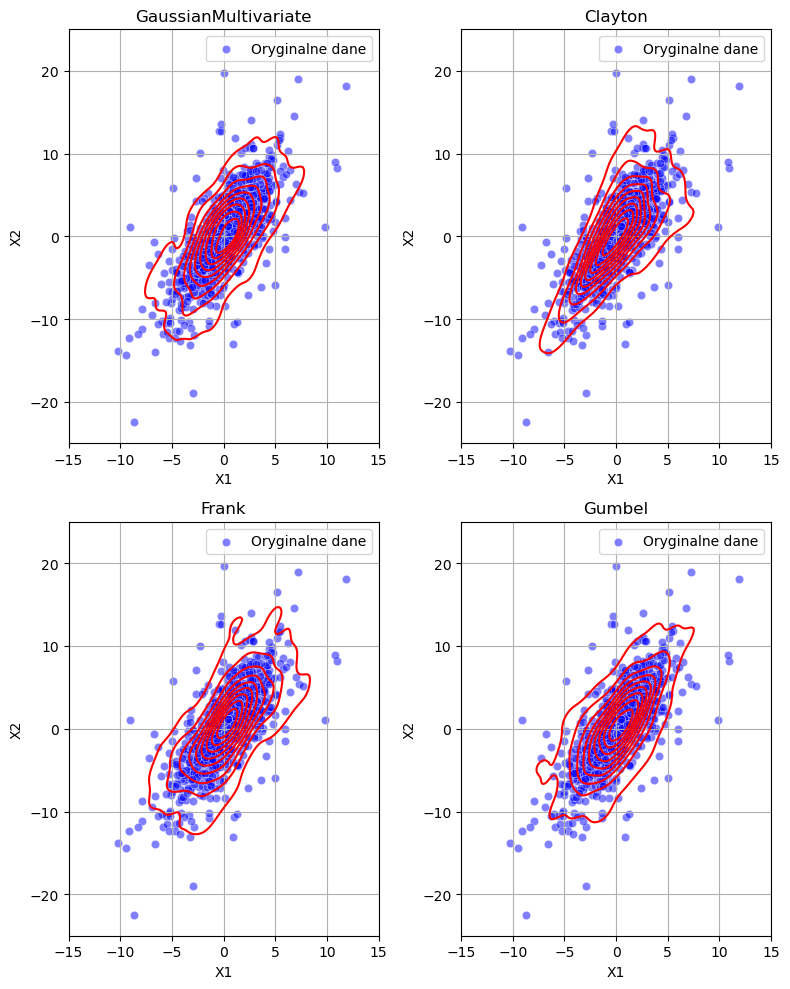

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(8, 10))
axes = ax.flatten()

for i, (samples_real_df, title) in enumerate(samples_real):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    sns.kdeplot(x=samples_real_df["X1"], y=samples_real_df["X2"], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Wszystkie kopuły wyglądają dosyć podobnie, lecz każda kopuła dobrze odwzorowuje inne aspekty zależności. Gaussian Multivariate jest ogólna (z tym, że numeryczne wyniki są podejrzane), Clayton skupia się na dolnych wartościach, Gumbel na wysokich wartościach, a Frank jest najbardziej neutralna.

---

## Parametry theta - porównanie
Parametry kopuł (Copulas):

In [50]:
results2 = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)

    # Wyodrębnianie parametrów
    if isinstance(copula, GaussianMultivariate):
        correlation_matrix = copula.correlation
        params = {
            'correlation_matrix': correlation_matrix
        }
    else:
        theta = copula.theta
        params = {'theta': theta}

    results2.append({
        'Copula': copula_class.__name__,
        'Params': params
    })

# Tworzenie tabeli
params_df2 = pd.DataFrame(results2)
print(params_df2) # parametry dopasowanych kopuł z Copulas

                 Copula                          Params
0  GaussianMultivariate  {'correlation_matrix': [0, 1]}
1               Clayton   {'theta': 2.5264744541704784}
2                 Frank    {'theta': 6.907463392562251}
3                Gumbel   {'theta': 2.2632372270852392}


Parametry kopuł (Sklarpy):

In [51]:
print(params_df) # parametry dopasowanych kopuł z Sklarpy

    Copula  Parametr Theta
0  Clayton       28.991157
1   Gumbel       10.273737
2    Frank       31.689794


Porównując parametr $\theta$ dopasowanych kopuł archimedejskich z Sklarpy i Copulas widzimy sporą różnicę. Najlepszą kopułą w obu przypadkach była kopuła Franka. Sprawdzimy, czy otrzymamy te same wyniki AIC/BIC, jeśli dla kopuły Franka z obu bibliotek przyjmiemy to samo $\theta$.

In [52]:
# Kopuła Franka ze sklarpy, musimy podać theta z copulas
frank = frank_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals, theta=6.909811222142677)

wyniki = pd.DataFrame({
    "Copula": ["Frank"],
    "Log-Likelihood": [frank.loglikelihood()],
    "AIC": [frank.aic()],
    "BIC": [frank.bic()],
    "Theta": [frank.copula_params.theta]
})
print(wyniki) # kopuła Sklarpy z narzuconym theta

  Copula  Log-Likelihood          AIC          BIC      Theta
0  Frank    -2571.220312  5158.440624  5197.742567  31.689794


Jak widać narzucona $\theta$ została zastąpiona dopasowanym parametrem. W sklarpy nie da się podać wartości $\theta$ bez dopasowania kopuły.

In [53]:
print(results_sorted.loc[0]) # kopuła Copulas
print()
print(params_df2.loc[2]["Params"])

Copula                 Frank
Num_params               1.0
Log-Likelihood    409.988001
AIC              -817.976002
BIC              -813.063259
Name: 0, dtype: object

{'theta': 6.907463392562251}


Spróbujemy narzucić $\theta$ z kopuły Franka Sklarpy kopule Franka z Copulas.

In [54]:
frank_copulas = Frank()

frank_copulas.fit(data_u)
frank_copulas.theta = 32.147256

# Obliczenie gęstości prawdopodobieństwa (PDF)
pdf_values = frank_copulas.probability_density(data_u)

# Log-likelihood
log_likelihood = np.sum(np.log(pdf_values))
num_params = 1
n = len(data_u)

# AIC i BIC
aic = -2 * log_likelihood + 2 * num_params
bic = -2 * log_likelihood + num_params * np.log(n)

# Wyświetlenie wyników
wyniki2 = pd.DataFrame({
    'Copula': ['Frank'],
    'Theta': [frank_copulas.theta],
    'Log-Likelihood': [log_likelihood],
    'AIC': [aic],
    'BIC': [bic]
})

print(wyniki2) # kopuła Copulas z narzuconym theta

  Copula      Theta  Log-Likelihood  AIC  BIC
0  Frank  32.147256            -inf  inf  inf


In [55]:
print(kopules.loc[4]) # kopuła Sklarpy

Copula                  Frank
Log-Likelihood   -2571.220312
AIC               5158.440624
BIC               5197.742567
Name: 4, dtype: object


W kopule Franka z Copulas z narzuconą $\theta$=32.147256 (dużo wyższa wartość niż dopasowana 6.909811) mamy wyniki w nieskończonościach. Im większe $\theta$ tym silniejsze zależności modeluje kopuła. Nie da się porównać implementacji z tych dwóch bibliotek. Trzeba się zdecydować na jedną bibliotekę.

---

## Test Mardia
Możemy wykonać test na wielowymiarową normalność:

In [56]:
mardia_test = multivariate_normality(data[["diff_aapl", "diff_msft"]], alpha=0.05)

print("Test Mardia:")
print(mardia_test)

Test Mardia:
HZResults(hz=11.058750172183926, pval=1.721878102347852e-24, normal=False)


Niska wartość p oznacza, że możemy odrzucić hipotezę zerową, czyli założenie, że dane są wielowymiarowo normalne.

Narysujemy elipsę ufności:

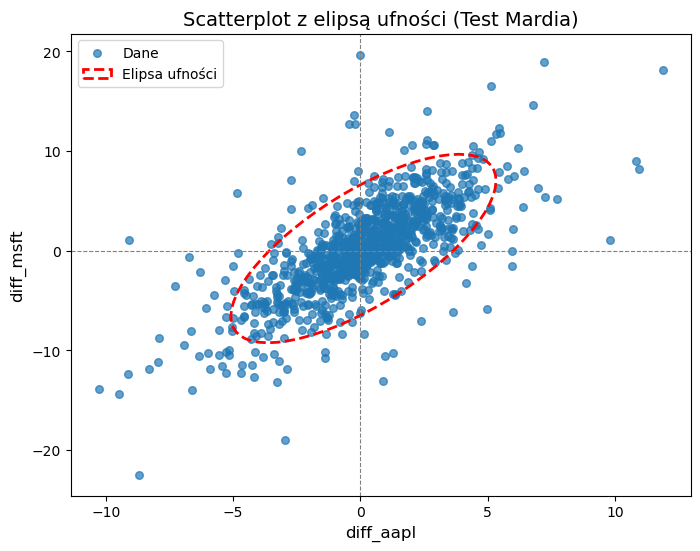

In [57]:
# Funkcja do rysowania elipsy ufności
def plot_with_confidence_ellipse(data_x, data_y, ax, n_std=2.0, **kwargs):
    if len(data_x) != len(data_y):
        raise ValueError("data_x i data_y muszą mieć tę samą długość")
    
    # Obliczanie średniej i macierzy kowariancji
    mean_x = np.mean(data_x)
    mean_y = np.mean(data_y)
    cov_matrix = np.cov(data_x, data_y)
    
    # Wartości własne i wektory własne
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Kąt elipsy
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Wymiary elipsy
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    
    # Dodanie elipsy do wykresu
    ellipse = Ellipse((mean_x, mean_y), width, height, angle, **kwargs)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(data["diff_aapl"], data["diff_msft"], s=30, alpha=0.7, label="Dane")

plot_with_confidence_ellipse(
    data["diff_aapl"], data["diff_msft"], ax, n_std=2.0,
    edgecolor='red', facecolor='none', linewidth=2, linestyle='--', label="Elipsa ufności"
)

ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_title("Scatterplot z elipsą ufności (Test Mardia)", fontsize=14)
ax.set_xlabel("diff_aapl", fontsize=12)
ax.set_ylabel("diff_msft", fontsize=12)
ax.legend()
plt.show()

Możemy policzyć ile punktów z rozkładu dwuwymiarowego znajduje się poza elipsą ufności:

In [58]:
# Obliczanie średnich i macierzy kowariancji
mean_vector = [np.mean(data["diff_aapl"]), np.mean(data["diff_msft"])]
cov_matrix = np.cov(data["diff_aapl"], data["diff_msft"])
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Obliczanie odległości Mahalanobisa dla każdego punktu
mahal_distances = data.apply(
    lambda row: mahalanobis(row[["diff_aapl", "diff_msft"]], mean_vector, inv_cov_matrix), axis=1
)

data["mahal_dist"] = mahal_distances

# Obliczanie progu dla poziomu ufności 95% (chi-kwadrat rozkład z 2 stopniami swobody)
threshold = np.sqrt(chi2.ppf(0.95, df=2))

# Zliczanie punktów poza elipsą
points_outside = data[data["mahal_dist"] > threshold]
percent_outside = len(points_outside) / len(data) * 100

print(f"Liczba punktów poza elipsą: {len(points_outside)}")
print(f"Procent punktów poza elipsą: {percent_outside:.2f}%")

Liczba punktów poza elipsą: 73
Procent punktów poza elipsą: 7.26%


Sugestią do braku wielowymiarowości normalnej jest ilość punktów poza elipsą przekraczająca 5%.

## Krok 4a
Wygenerować N wektorów ($x_1$,$x_2$), gdzie $x_1$ pochodzą z pierwszego rozkładu brzegowego, a $x_2$ z drugiego, więc rozkłady są niezależne.\
Dopasować $\beta \in [0,1]$ tak, żeby VaR portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy.\
Zinterpretować wartość $\beta$.

In [59]:
N = 10000
beta_range = np.linspace(0, 1, 101)

Generujemy próbki z rozkładów brzegowych (niezależnie):

In [60]:
samples_x1 = marginal_aapl.sample(N)
samples_x2 = marginal_msft.sample(N)
samples_x1, samples_x2

(array([ 2.72598111,  3.36722305, -2.78576308, ..., -1.74714746,
         0.09264726,  1.54533632]),
 array([-1.3693835 , -0.98958644, -3.07949304, ...,  2.47844758,
        -3.09131053, 22.90311651]))

Obliczamy VaR dla portfela dla różnych wartości $\beta$:

In [61]:
var_results = []

for beta in beta_range:
    portfolio_values = beta * samples_x1 + (1 - beta) * samples_x2
    VaR_95 = np.quantile(portfolio_values, 0.05)
    var_results.append((beta, VaR_95))

var_results = pd.DataFrame(var_results, columns=["Beta", "VaR"])
print(var_results)

     Beta       VaR
0    0.00 -7.176747
1    0.01 -7.106458
2    0.02 -7.017635
3    0.03 -6.948405
4    0.04 -6.886620
..    ...       ...
96   0.96 -3.732110
97   0.97 -3.765402
98   0.98 -3.792043
99   0.99 -3.819328
100  1.00 -3.867993

[101 rows x 2 columns]


Aby zminimalizować straty, należy maksymalizować wartość VaR, ponieważ wartości strat są ujemne. Zatem poszukujemy takiego $\beta$, dla którego VaR jest najmniej negatywny (największy z ujemnych):

In [62]:
optimal_row = var_results.loc[var_results["VaR"].idxmax()]
optimal_beta = optimal_row["Beta"]
optimal_var = optimal_row["VaR"]
print(f"Optymalne beta: {optimal_beta}")
print(f"Minimalne VaR: {optimal_var}")

Optymalne beta: 0.8
Minimalne VaR: -3.357582728866827


$\beta$ wynosi 0.76, co oznacza, że 76% portfela powinno być zainwestowane w aktywo $x_1$, a pozostałe 24% w aktywo $x_2$. Minimalne VaR wynosi -3.5851898914415172, co oznacza, że przy 95% poziomie ufności, maksymalna strata portfela nie przekroczy tej wartości.

Interpretacja wartości $\beta$:

$\beta = 0.76$: Oznacza to, że większa część portfela powinna być zainwestowana w aktywo $x_1$, ponieważ to minimalizuje ryzyko straty.

Minimalne VaR: Wartość VaR oznacza, że portfel jest tak skonstruowany, aby straty były jak najmniejsze. Wartość VaR jest najmniej negatywna, co oznacza, że portfel jest optymalnie rozłożony między różne aktywa, aby zminimalizować potencjalne straty.

## Krok 4b
Wygenerować N wektorów $(x_1,x_2)$ z kopuły.\
Dopasować $\beta \in [0,1]$ tak, żeby VaR portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy.\
Zinterpretować wartość $\beta$.

### Sklarpy - generuje samples już przetransformowane do wartości rzeczywistych

In [63]:
frank_samples = frank_fit.rvs(N)

var_results_frank = []

for beta in beta_range:
    portfolio_values_frank = beta * frank_samples[:, 0] + (1 - beta) * frank_samples[:, 1]
    VaR_95_frank = np.quantile(portfolio_values_frank, 0.05)
    var_results_frank.append((beta, VaR_95_frank))

var_results_frank = pd.DataFrame(var_results_frank, columns=["Beta", "VaR"])
print(var_results_frank)

optimal_row_frank = var_results_frank.loc[var_results_frank["VaR"].idxmax()]
optimal_beta_frank = optimal_row_frank["Beta"]
optimal_var_frank = optimal_row_frank["VaR"]
print(f"Optymalne beta dla próbek z kopuły Franka: {optimal_beta_frank}")
print(f"Minimalne VaR dla próbek z kopuły Franka: {optimal_var_frank}")

     Beta       VaR
0    0.00 -7.169480
1    0.01 -7.139705
2    0.02 -7.115170
3    0.03 -7.103261
4    0.04 -7.065613
..    ...       ...
96   0.96 -3.997060
97   0.97 -3.967025
98   0.98 -3.941272
99   0.99 -3.920879
100  1.00 -3.888947

[101 rows x 2 columns]
Optymalne beta dla próbek z kopuły Franka: 1.0
Minimalne VaR dla próbek z kopuły Franka: -3.888947338140476


### Copulas
Generujemy próbki z dopasowanej kopuły Franka:

In [64]:
copula = Frank()
copula.fit(data_u)
samples_copula = copula.sample(n_samples=N)

Ponieważ próbki wygenerowane z kopuły należą do przedziału (0,1) musimy je przetransformować z powrotem do wartości rzeczywistych:

In [65]:
samples_x1_copula = marginal_aapl.ppf(samples_copula[:, 0])
samples_x2_copula = marginal_msft.ppf(samples_copula[:, 1])
samples_x1_copula, samples_x2_copula

(array([ 3.12510901, -1.24002092,  0.31901133, ...,  5.03858429,
         1.36702483, -4.17892976]),
 array([  5.31980383,   1.4005075 ,  -0.59907018, ...,   5.34473734,
         -1.1601    , -22.02461855]))

Obliczamy VaR dla portfela dla różnych wartości beta:

In [66]:
var_results_copula = []

for beta in beta_range:
    portfolio_values_copula = beta * samples_x1_copula + (1 - beta) * samples_x2_copula
    VaR_95_copula = np.quantile(portfolio_values_copula, 0.05)
    var_results_copula.append((beta, VaR_95_copula))

var_results_copula = pd.DataFrame(var_results_copula, columns=["Beta", "VaR"])
print(var_results_copula)

     Beta       VaR
0    0.00 -7.111524
1    0.01 -7.065745
2    0.02 -7.011323
3    0.03 -6.967045
4    0.04 -6.923933
..    ...       ...
96   0.96 -3.982952
97   0.97 -3.968369
98   0.98 -3.969563
99   0.99 -3.961017
100  1.00 -3.945102

[101 rows x 2 columns]


Aby zminimalizować straty i wyznaczyć optymalne $\beta$, będziemy maksymalizować wartość VaR:

In [67]:
optimal_row_copula = var_results_copula.loc[var_results_copula["VaR"].idxmax()]
optimal_beta_copula = optimal_row_copula["Beta"]
optimal_var_copula = optimal_row_copula["VaR"]
print("Copulas")
print(f"Optymalne beta dla próbek z kopuły: {optimal_beta_copula}")
print(f"Minimalne VaR dla próbek z kopuły: {optimal_var_copula}")

Copulas
Optymalne beta dla próbek z kopuły: 1.0
Minimalne VaR dla próbek z kopuły: -3.9451017637850234


In [68]:
print("4a")
print(f"Optymalne beta: {optimal_beta}")
print(f"Minimalne VaR: {optimal_var}")
print()
print("Sklarpy")
print(f"Optymalne beta dla próbek z kopuły Franka: {optimal_beta_frank}")
print(f"Minimalne VaR dla próbek z kopuły Franka: {optimal_var_frank}")

4a
Optymalne beta: 0.8
Minimalne VaR: -3.357582728866827

Sklarpy
Optymalne beta dla próbek z kopuły Franka: 1.0
Minimalne VaR dla próbek z kopuły Franka: -3.888947338140476


**4a:** Wartość $\beta$ = 0.76 sugeruje, że portfel jest bardziej zrównoważony między dwoma aktywami, co prowadzi do mniejszej straty (mniej negatywne VaR).

**4b:** Wartość $\beta$ = 1.0 sugeruje, że portfel powinien być w całości zainwestowany w jedno aktywo ($x_1$), co prowadzi do większej straty (bardziej negatywne VaR).

**Dywersyfikacja portfela:** Wartość $\beta$ = 0.76 w przypadku 4a pokazuje, że dywersyfikacja portfela między dwoma aktywami może prowadzić do mniejszych strat w porównaniu do inwestowania w jedno aktywo, jak w przypadku 4b.

**Ryzyko straty:** Minimalne VaR w przypadku 4a jest mniej negatywne niż w przypadku 4b, co oznacza, że portfel z dywersyfikacją ma mniejsze ryzyko straty.

**Optymalizacja portfela:** Wartość $\beta$ = 0.76 w przypadku 4a jest bardziej optymalna dla minimalizacji ryzyka straty w porównaniu do $\beta$ = 1.0 w przypadku 4b.

Za pomocą wykresu możemy porównać zmiany wartości VaR w zależności od β dla obu przypadków: z niezależnymi rozkładami (4a) oraz z kopułą Franka (4b):

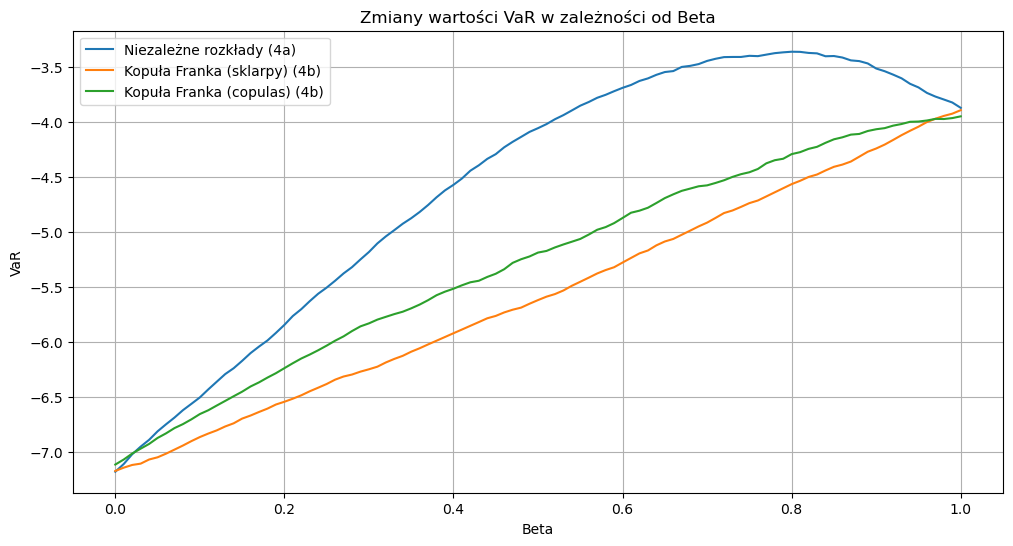

In [69]:
plt.figure(figsize=(12, 6))

plt.plot(var_results["Beta"], var_results["VaR"], label="Niezależne rozkłady (4a)")
plt.plot(var_results_frank["Beta"], var_results_frank["VaR"], label="Kopuła Franka (sklarpy) (4b)")
plt.plot(var_results_copula["Beta"], var_results_copula["VaR"], label="Kopuła Franka (copulas) (4b)")

plt.xlabel("Beta")
plt.ylabel("VaR")
plt.title("Zmiany wartości VaR w zależności od Beta")
plt.legend()
plt.grid(True)
plt.show()

Na wykresie widać, jak zmienia się ryzyko portfela przy różnych proporcjach aktywów. W przypadku niezależnych rozkładów, krzywa VaR jest wygięta, co sugeruje większą korzyść z dywersyfikacji. Natomiast przy zastosowaniu kopuły, krzywa jest bardziej stroma, co wskazuje na większe ryzyko przy pełnej koncentracji na jednym aktywie.

### Dlaczego β z kopuły są wyższe?

Kiedy modelujemy dane za pomocą kopuły, uwzględniamy jak te aktywa współdziałają ze sobą. Jeśli aktywa są silnie skorelowane (Apple i Microsoft mają tendencję do wspólnego wzrostu lub spadku), to dywersyfikacja (podział portfela między różne aktywa) staje się mniej efektywna.\
Nie możemy "rozłożyć" ryzyka na różne aktywa w taki sposób, jak byśmy to robili w przypadku aktywów niezależnych. Optymalne $\beta$ z kopuły będzie wyższe, bo koncentracja na jednym aktywie (np. większa część portfela w Apple) może minimalizować ryzyko w takim przypadku, gdzie zależności między aktywami zwiększają ryzyko skrajnych strat. Wyższe $\beta$ sugeruje, że silne powiązanie między aktywami skłania do większej koncentracji na jednym z nich.

## Krok 5
Porównać wyniki z 4a i 4b. Sprawdzić, jak zmieniają się wyniki dla dwóch różnych poziomów VaR i wartości N. Skomentować.

Porównamy jak zmieniają się wyniki dla VaR 95% i 99% oraz dla próbek w ilości 1000, 10000 i 50000:

In [70]:
VaR_levels = [0.05, 0.01]
N_values = [1000, 10000, 50000]

comparison_results = []

for var_level in VaR_levels:
    for N in N_values:
        samples_x1 = marginal_aapl.sample(N)
        samples_x2 = marginal_msft.sample(N)
        portfolio_values = beta_range[:, None] * samples_x1 + (1 - beta_range[:, None]) * samples_x2.T
        # kopuła z Copulas
        samples_copula = copula.sample(n_samples=N)
        samples_x1_copula = marginal_aapl.ppf(samples_copula[:, 0])
        samples_x2_copula = marginal_msft.ppf(samples_copula[:, 1])
        portfolio_values_copula = beta_range[:, None] * samples_x1_copula + (1 - beta_range[:, None]) * samples_x2_copula.T
        
        var_independent = np.quantile(portfolio_values, var_level, axis=1)
        var_copula = np.quantile(portfolio_values_copula, var_level, axis=1)
        
        comparison_results.append({
            "Poziom VaR": (1-var_level)*100,
            "N": N,
            "Optymalne beta": beta_range[np.argmax(var_independent)],
            "Minimalne VaR": var_independent[np.argmax(var_independent)],
            "Optymalne beta z kopuły": beta_range[np.argmax(var_copula)],
            "Minimalne VaR z kopuły": var_copula[np.argmax(var_copula)]
        })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

   Poziom VaR      N  Optymalne beta  Minimalne VaR  Optymalne beta z kopuły  \
0        95.0   1000            0.78      -3.414332                     0.94   
1        95.0  10000            0.77      -3.522038                     1.00   
2        95.0  50000            0.76      -3.444182                     1.00   
3        99.0   1000            0.78      -5.029886                     0.88   
4        99.0  10000            0.69      -5.571843                     0.93   
5        99.0  50000            0.73      -5.517594                     0.90   

   Minimalne VaR z kopuły  
0               -4.300138  
1               -3.878828  
2               -3.981131  
3               -5.690666  
4               -6.550675  
5               -6.583962  


## Wnioski

**Wpływ poziomu VaR:**\
Optymalne 𝛽 są wyższe na poziome VaR (99%), co sugeruje większą koncentrację inwestycji w jedno aktywo.

**Wpływ liczby próbek (N):**\
Wzrost liczby próbek (N) prowadzi do stabilizacji wyników. Optymalne $\beta$ i minimalne VaR są bardziej zbliżone dla większych wartości N.\
Dla poziomu VaR 95%, optymalne $\beta$ są nieco niższe przy większych wartościach N, co sugeruje bardziej zrównoważony portfel.\
Dla poziomu VaR 99%, optymalne $\beta$ są bardziej zmienne, ale ogólnie wyższe niż dla poziomu VaR 95%.

### Co jest bliższe rzeczywistości?

Metoda zależy od danych: Nie możemy dowolnie wybierać, czy chcemy mieć aktywa niezależne, czy zależne – to zależy od tego, jak faktycznie zachowują się aktywa w rzeczywistości. Jeżeli aktywa są silnie skorelowane (np. Apple i Microsoft często poruszają się w podobny sposób), to musimy uwzględnić zależności między nimi za pomocą kopuły.
- Założenie niezależności (krok 4a) może prowadzić do niedoszacowania ryzyka, ponieważ zakłada, że aktywa nie wpływają na siebie, a w rzeczywistości mogą. Dlatego może się zdarzyć, że wyniki będą bardziej optymistyczne, bo zakłada się, że ryzyko można "rozłożyć".
- Kopuła (krok 4b) jest bardziej konserwatywna, ponieważ lepiej uwzględnia zależności między aktywami. Wskazuje to na większe ryzyko, szczególnie w ekstremalnych przypadkach (np. kryzysach), gdy aktywa powiązane silnie tracą równocześnie.